In [17]:
#Importamos las librerias

import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error



In [18]:
# Descargue los datos reales de http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Se extrae los datos descargados 
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)
df.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [19]:
"""
Primero, es necesario realizar un preprocesamiento para codificar usuarios y películas como índices enteros.
"""
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)

min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Numero de usuarios: {}, Numero de peliculas: {}, Calificacion minima: {}, Maxima calificacion: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)


Numero de usuarios: 610, Numero de peliculas: 9724, Calificacion minima: 0.5, Maxima calificacion: 5.0


In [20]:
#Separacion en train y test
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values

# Normaliza los objetivos entre 0 y 1. Facilita el entrenamiento.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Asumiendo capacitación en el 90% de los datos y validando en el 10%.
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


In [21]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001), metrics=["mae", "acc"]
)

#model.summary()

In [22]:
import time
"""
## Entrene el modelo basado en la división de datos
"""
start = time.time()

history = model.fit(x=x_train,y=y_train,batch_size=64,epochs=20,verbose=1,validation_data=(x_val, y_val),)

print("Time finish:",time.time() - start)


Epoch 1/20
1261/1261 [==============================] - 7s 6ms/step - loss: 0.6379 - mae: 0.1883 - acc: 0.1271 - val_loss: 0.6206 - val_mae: 0.1698 - val_acc: 0.1304
Epoch 2/20
1261/1261 [==============================] - 7s 6ms/step - loss: 0.6147 - mae: 0.1642 - acc: 0.1327 - val_loss: 0.6207 - val_mae: 0.1733 - val_acc: 0.1334
Epoch 3/20
1261/1261 [==============================] - 7s 6ms/step - loss: 0.6089 - mae: 0.1584 - acc: 0.1341 - val_loss: 0.6151 - val_mae: 0.1670 - val_acc: 0.1334
Epoch 4/20
1261/1261 [==============================] - 7s 5ms/step - loss: 0.6082 - mae: 0.1574 - acc: 0.1348 - val_loss: 0.6146 - val_mae: 0.1663 - val_acc: 0.1336
Epoch 5/20
1261/1261 [==============================] - 7s 5ms/step - loss: 0.6067 - mae: 0.1557 - acc: 0.1351 - val_loss: 0.6137 - val_mae: 0.1648 - val_acc: 0.1329
Epoch 6/20
1261/1261 [==============================] - 7s 5ms/step - loss: 0.6061 - mae: 0.1547 - acc: 0.1353 - val_loss: 0.6133 - val_mae: 0.1642 - val_acc: 0.1328
Epoc

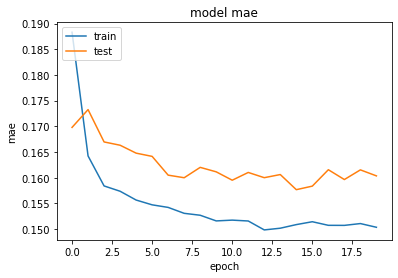

In [23]:
"""
## Grafica de error MAE
"""
plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])
plt.title("model mae")
plt.ylabel("mae")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

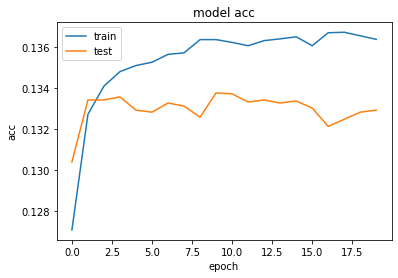

In [24]:
"""
## Grafica de error ACC
"""
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("model acc")
plt.ylabel("acc")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [25]:
print("Error medio train", np.mean(history.history["mae"]))
print("Error medio test", np.mean(history.history["val_mae"]))

Error medio train 0.1549534596502781
Error medio test 0.16246821433305741


In [26]:
"""
## Mostrar las 10 mejores recomendaciones de películas para una usuaria.
"""

movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))

ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]

In [27]:
predictions = model.predict(user_movie_array)
print(x_val.size)
print(ratings.size)
print(y.size)

40336
9648
100836


In [28]:
#test_performance = mean_absolute_error(test["rating"], ratings)
#print(" Test Mae model 2 : %s " % test_performance)


print("Mostrando recomendaciones para la usuaria: {}".format(user_id))
print("====" * 9)
print("Películas con altas calificaciones del usuario")
print("----" * 8)

top_movies_user = (movies_watched_by_user.sort_values(by="rating", ascending=False).head(5).movieId.values)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]

for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Las 10 mejores recomendaciones de películas")
print("----" * 8)

recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Mostrando recomendaciones para la usuaria: 241
Películas con altas calificaciones del usuario
--------------------------------
Before Sunrise (1995) : Drama|Romance
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) : Comedy|Romance
Before Sunset (2004) : Drama|Romance
Before Midnight (2013) : Drama|Romance
Her (2013) : Drama|Romance|Sci-Fi
--------------------------------
Las 10 mejores recomendaciones de películas
--------------------------------
Philadelphia Story, The (1940) : Comedy|Drama|Romance
Rear Window (1954) : Mystery|Thriller
Ran (1985) : Drama|War
Touch of Evil (1958) : Crime|Film-Noir|Thriller
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller
Cool Hand Luke (1967) : Drama
Man Bites Dog (C'est arrivé près de chez vous) (1992) : Comedy|Crime|Drama|Thriller
Boondock Saints, The (2000) : Action|Crime|Drama|Thriller
Double Indemnity (1944) : Crime|Drama|Film-Noir
Departed, The (2006) : Crime|Drama|Thriller
